**Setup**  
First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### 分类

#### MNIST

在本章当中，我们将会使用 MNIST 这个数据集，它有着 70000 张规格较小的手写数字图片，由美国的高中生和美国人口调查局的职员手写而成。这相当于机器学习当中的“Hello World”，人们无论什么时候提出一个新的分类算法，都想知道该算法在这个数据集上的表现如何。机器学习的初学者迟早也会处理 MNIST 这个数据集。

Scikit-Learn 提供了许多辅助函数，以便于下载流行的数据集。MNIST 是其中一个。下面的代码获取 MNIST



**Warning**: fetch_mldata() is deprecated since Scikit-Learn 0.20. You should use fetch_openml() instead. However, it returns the unsorted MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

一般而言，由 sklearn 加载的数据集有着相似的字典结构，这包括：

- DESCR键描述数据集
- data键存放一个数组，数组的一行表示一个样例，一列表示一个特征
- target键存放一个标签数组

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

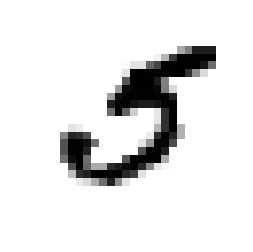

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

plt.show()

In [7]:
y[36000]

5

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

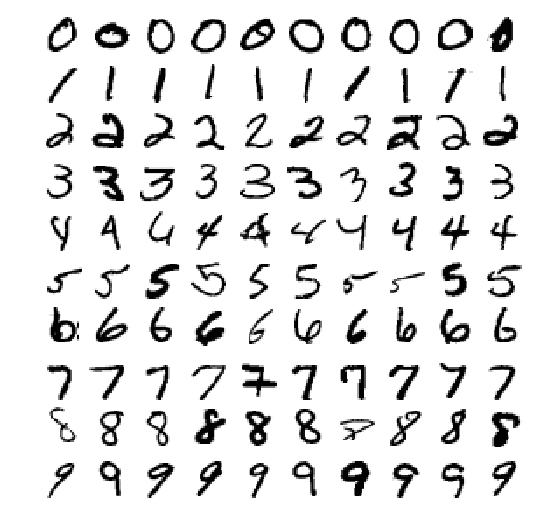

In [10]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

先等一下！你总是应该先创建测试集，并且在验证数据之前先把测试集晾到一边。MNIST 数据集已经事先被分成了一个训练集（前 60000 张图片）和一个测试集（最后 10000 张图片）

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

打乱训练集。这可以保证交叉验证的每一折都是相似（你不会期待某一折缺少某类数字）。而且，一些学习算法对训练样例的顺序敏感，当它们在一行当中得到许多相似的样例，这些算法将会表现得非常差。打乱数据集将保证这种情况不会发生。

In [12]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#### 训练一个二分类器 Training a Binary Classifier


下面建立一个二分类器，识别是5 或者不是5

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

用随机梯度下降分类器 SGD，是一个不错的开始。使用 Scikit-Learn 的SGDClassifier类。这个分类器有一个好处是能够高效地处理非常大的数据集。这部分原因在于SGD一次只处理一条数据，这也使得 SGD 适合在线学习（online learning）。

In [14]:
from sklearn.linear_model import SGDClassifier
# from sklearn.linear_model import LogisticRegression

sgd_clf = SGDClassifier(random_state=2020)
sgd_clf.fit(X_train, y_train_5)

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=2020, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

> SGDClassifier依赖于训练集的随机程度（所以被命名为 stochastic，随机之义）。如果你想重现结果，你应该固定参数random_state

In [15]:
# 查出数字 5 的图片
sgd_clf.predict([X[36000]])

array([False])

分类器猜测这个数字代表 5（True）。看起来在这个例子当中，它猜对了。现在让我们评估这个模型的性能。但是它猜错了。。。

In [16]:
y[36000]

5

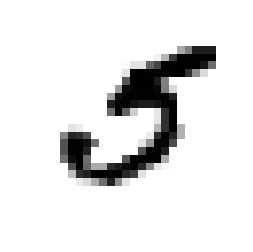

In [17]:
plot_digit(some_digit)

#### 对性能的评估 Performance Measures

评估一个模型的好方法是使用交叉验证，在交叉验证过程中，有时候你会需要更多的控制权，相较于函数cross_val_score()或者其他相似函数所提供的功能。这种情况下，你可以实现你自己版本的交叉验证。事实上它相当简单。以下代码粗略地做了和cross_val_score()相同的事情，并且输出相同的结果。

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=2020)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds, X_test_folds = X_train[train_index], X_train[test_index]
    y_train_folds, y_test_folds = y_train_5[train_index], y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.96525


C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.93395


C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.95425


> StratifiedKFold类实现了分层采样（详见第二章的解释），生成的折（fold）包含了各类相应比例的样例。在每一次迭代，上述代码生成分类器的一个克隆版本，在训练折（training folds）的克隆版本上进行训练，在测试折（test folds）上进行预测。然后它计算出被正确预测的数目和输出正确预测的比例。

让我们使用cross_val_score()函数来评估SGDClassifier模型，同时使用 K 折交叉验证，此处让k=3。记住：K 折交叉验证意味着把训练集分成 K 折（此处 3 折），然后使用一个模型对其中一折进行预测，对其他折进行训练。

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

array([0.96525, 0.93395, 0.95425])

在交叉验证上有大于 95% 的精度（accuracy）？这看起来很令人吃惊。先别高兴，让我们来看一个非常笨的分类器去分类，看看其在“非 5”这个类上的表现。

In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

**没错，这个笨的分类器也有 90% 的精度。这是因为只有 10% 的图片是数字 5，所以你总是猜测某张图片不是 5，你也会有90%的可能性是对的。**  

**这证明了为什么精度通常来说不是一个好的性能度量指标，特别是当你处理有偏差的数据集，比方说其中一些类比其他类频繁得多。** 

##### Confusion Matrix - 混淆矩阵

对分类器来说，一个好得多的性能评估指标是混淆矩阵。大体思路是：输出类别A被分类成类别 B 的次数。举个例子，为了知道分类器将 5 误分为 3 的次数，你需要查看混淆矩阵的第五行第三列。

为了计算混淆矩阵，首先你需要有一系列的预测值，这样才能将预测值与真实值做比较。你或许想在测试集上做预测。但是我们现在先不碰它。（记住，只有当你处于项目的尾声，当你准备上线一个分类器的时候，你才应该使用测试集）。相反，你应该使用cross_val_predict()函数

In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

就像 cross_val_score()，cross_val_predict()也使用 K 折交叉验证。它不是返回一个评估分数，而是返回基于每一个测试折做出的一个预测值。这意味着，对于每一个训练集的样例，你得到一个干净的预测（“干净”是说一个模型在训练过程当中没有用到测试集的数据）。

现在使用 confusion_matrix()函数，你将会得到一个混淆矩阵。传递目标类(y_train_5)和预测类（y_train_pred）给它。

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52579,  2000],
       [  931,  4490]], dtype=int64)

混淆矩阵中的每一行表示一个实际的类, 而每一列表示一个预测的类。该矩阵的第一行认为“非 5”（反例）中的 53272 张被正确归类为 “非 5”（他们被称为真反例，true negatives）, 而其余 1307 被错误归类为"是 5" （假正例，false positives）。第二行认为“是 5” （正例）中的 1077 被错误地归类为“非 5”（假反例，false negatives），其余 4344 正确分类为 “是 5”类（真正例，true positives）。

negative class  [[ **true negatives** , **false positives** ],
 
positive class  [ **false negatives** , **true positives** ]]

第一行考虑**非5**的图片，**negative class** ：

* true negatives：53,272 张被正确的分类为非5
* false positives：1307张被错误的分类为5

第一行考虑**是5**的图片，**positive class** ：

* false negatives：1077张错误的分类为非5
* true positives： 4344张被正确的分类为5

一个完美的分类器应该只有 **真正例 true positives** 和 **真反例 true negatives**, 即主对角线（左上至右下）元素不为0，其余元素为0

In [25]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

##### Precision and Recall 准确率与召回率

混淆矩阵可以提供很多信息。有时候你会想要更加简明的指标。一个有趣的指标是正例预测的精度，也叫做分类器的准确率（precision）。  
想要一个完美的准确率，一个平凡的方法是构造一个单一正例的预测和确保这个预测是正确的（precision = 1/1 = 100%）。但是这什么用，因为分类器会忽略所有样例，除了那一个正例。所以准确率一般会伴随另一个指标一起使用，这个指标叫做召回率（recall），也叫做敏感度（sensitivity）或者真正例率（true positive rate， TPR）。这是正例被分类器正确探测出的比率。

**$ precision = \frac {TP} {TP + FP} $**

**$ recall = \frac {TP} {TP + FN} $**

* TP is the number of true positives
* FP is the number of false positives
* FN is of course the number of false negatives.  
* 其中 TP 是真正例的数目，FP 是假正例的数目，FN 是假反例的数目。

Scikit-Learn 提供了一些函数去计算分类器的指标，包括准确率和召回率。

In [26]:
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_train_pred) # 4344 / (4344 + 1307)

0.6918335901386748

In [29]:
recall_score(y_train_5, y_train_pred)

0.8282604685482383

当你去观察精度的时候，你的“数字 5 探测器”看起来还不够好。当它声明某张图片是 5 的时候，它只有 77% 的可能性是正确的。而且，它也只检测出“是 5”类图片当中的 79%。

通常结合准确率和召回率会更加方便，这个指标叫做“F1 值”，特别是当你需要一个简单的方法去比较两个分类器的优劣的时候。F1 值是准确率和召回率的调和平均。普通的平均值平等地看待所有的值，而调和平均会给小的值更大的权重。所以，要想分类器得到一个高的 F1 值，需要召回率和准确率同时高。

将**Precision** 和 **Recall**结合到一个称为**F1 score** 的量,，特别是在我们需要一种简单的方法来比较两个分类器。**F1 score**是精度和召回的调和平均值。常规均值平等地处理所有值，但调和平均值给予低值更多权重。 因此，如果召回和精确度都很高，分类器将只获得高F1分数。

$ F_1  = $ $2\over {1\over precision}+{1\over recall} $ $=$ $2×$ $precision×recall\over precision+recall $ $=$ $TP\over {TP}+{FN + FP\over 2}$


In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7539249433296953

$F_1$评分倾向于具有相似精度和召回率的分类器。这并不总是你想要的：在某些情况下，你最关心的是精确度，而在其他情况下，你真的很关心召回。例如：
* 如果您训练分类器来检测对孩子来说安全的视频，您可能更喜欢拒绝许多好视频的分类器（低召回率）但只保留安全分类（高精度），而不是一个具有更高召回率的分类器，这会让一些非常糟糕的视频出现在您的产品中（在这种情况下，您甚至可能希望添加人工管道来检查分类器的视频选择）。

* 另一方面，假设你训练一个分类器来检测监控图像上的商店扒手：如果你的分类器只有30％的精度，只要它有99％的召回率就可能很好（当然，保安人员会得到一些虚假警报，但几乎所有商店扒手都会被抓住）。

不幸的是，你无法双管齐下：提高精确度，减少召回率，反之亦然。这称为精确/召回权衡。

##### Precision/Recall Tradeoff 准确率/召回率之间的折衷

为了理解这种权衡，让我们看一下**SGDClassifier**是如何做出它的分类决定的。对于每个实例，它根据决策函数计算得分，如果该得分大于阈值，则将实例分配给**positive class**，否则将其分配给**negative class**。

下图显示了一些数字，从左侧最低分到右侧最高分。假设决策阈值位于中心箭头（两个5s之间）：您将在该阈值的右侧找到4个**true positives**（实际5s），和一个**false positive**（实际为6）。因此，使用该阈值，**准确率**为80％（5个中的4个）。但是在6个实际数字5中，分类器仅检测到4个，因此**召回率**为67％（6个中有4个）。

现在，如果你提高阈值（将其移动到右边的箭头），**false positive**（6）变为**true negative**，从而提高**准确率**（在这种情况下高达100％），但一个**true positive** 变为**false negative**，将**召回率**降低至50％。相反，降低阈值会**增加召回率**并**降低准确率**。

Scikit-Learn不允许您直接设置阈值，但它确实可以让您访问用于进行预测的决策分数。 您可以调用其**decision_function（）**方法，而不是调用分类器的**predict（）**方法，该方法返回每个实例的分数，然后使用您想要的**任何阈值**根据这些分数进行预测：

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-118.10023003])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

SGDClassifier用了一个等于 0 的阈值，所以前面的代码返回了跟predict()方法一样的结果（都返回了true）。让我们提高这个阈值：

In [35]:
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

这证明了提高阈值会降调召回率。这个图片实际就是数字 5，当阈值等于 0 的时候，分类器可以探测到这是一个 5，当阈值提高到 20000 的时候，分类器将不能探测到这是数字 5。  

那么如何决定使用哪个阈值？ 为此，您首先需要再次使用**cross_val_predict（)** 函数获得训练集中所有实例的分数，但这一次你希望它返回决策分数而不是预测：

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method="decision_function")

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

现在有了这些分数，您可以使用**precision_recall_curve（）** 函数计算所有可能的精度和召回率的阈值：

In [37]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

最后，您可以使用Matplotlib绘制**准确率**和**召回率**作为阈值的函数：

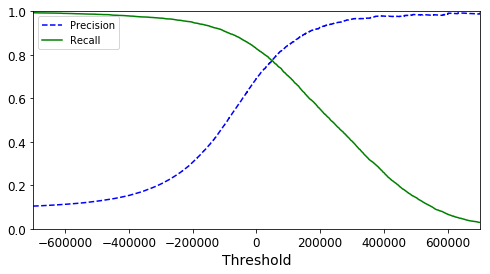

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

##### ROC curves ROC 曲线

**receiver operating characteristic (ROC)** 曲线是二元分类器的另一种常用工具。
* 它与精确度/召回曲线非常相似，但ROC曲线不是绘制精确度与召回率，而是绘制**true positive rate(TPR)** （召回的另一个名称）与**false positive rate(FPR)** 
* FPR是负面例子被错误归类为正面例子的比例。它等于**1 - true negative rate（TNR）**，即负面例子被正确归类为负面例子的比例。
* TNR也称为**specificity**。 

因此，ROC曲线绘制了**sensitivity**（召回）与 **1 – specificity** 。

要绘制ROC曲线，首先需要使用**roc_curve（）**函数计算各种阈值的**TPR和FPR**：

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

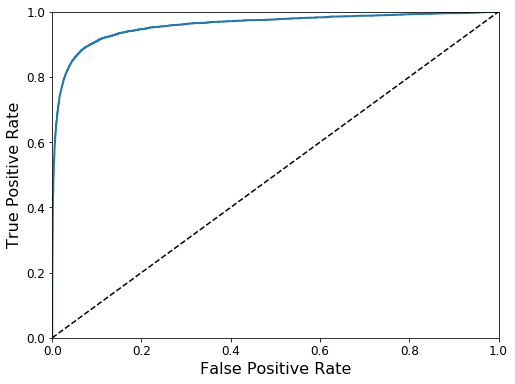

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
#save_fig("roc_curve_plot")
plt.show()

这里也有一个权衡：召回（TPR）越高，分类器产生的误报（FPR）越多。 **虚线表示纯随机分类器的ROC曲线**; 一个好的分类器尽可能远离该线（朝左上角）。

比较分类器的一种方法是测量曲线下面积（AUC）。完美分类器的ROC AUC**等于1**，而纯随机分类器的ROC AUC**等于0.5**。 Scikit-Learn提供了计算ROC AUC的函数：

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9587594409122335

根据经验，每当**positive class** 很少或者你**更关心false positives**而不是**false negatives**时，我们更倾向于使用PR曲线，否则使用ROC曲线。

下面我们训练一个**RandomForestClassifier**并将它的ROC曲线和ROC AUC得分与**SGDClassifier**做比较：

* 首先，我们需要获得训练集中每个实例的分数。 
* 但由于它的工作方式（见第7章），RandomForestClassi fier类没有decision_function（）方法。 
* 相反，它有一个**predict_proba（）**方法。 Scikit-Learn分类器通常有一个或另一个。
* **predict_proba（）**方法返回一个数组，这个数组的每一行包含一个实例，每一列代表一个类，每列包含给定实例属于给定类的概率（例如，图像内容表示5的概率为70％）：

In [44]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

C:\PyDev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


但是要画 ROC 曲线，你需要的是样例的分数，而不是概率。一个简单的解决方法是使用正例的概率当作样例的分数。

In [45]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

C:\PyDev\Anaconda3\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


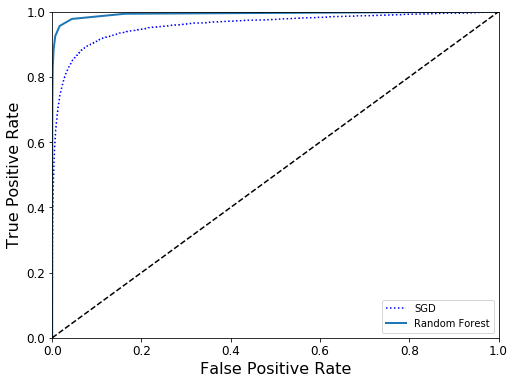

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

如你所见，RandomForestClassifier的 ROC 曲线比SGDClassifier的好得多：它更靠近左上角。所以，它的 ROC AUC 也会更大。

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [48]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

C:\PyDev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

准确率和召回率：98.5% 的准确率，82.8% 的召回率。还不错。

到现在我们已经知道如何训练二元分类器：
* 为您的任务选择适当的指标，
* 使用交叉验证评估您的分类器，
* 选择适合您需求的精确/召回权衡，
* 使用ROC曲线和ROC AUC分数比较各种模型。

**以上我们尝试检测的仅仅是5s，这属于二分类，结果只有两个：是或者不是。现在我们来解决多分类的问题**

#### Multiclass Classification-多类分类

二分类器只能区分两个类，而多类分类器（也被叫做多项式分类器）可以区分多于两个类。

一些算法（例如随机森林分类器或朴素贝叶斯分类器）是能够直接处理多个类。其他算法（例如支持向量机分类器或线性分类器）则是严格的二元分类器。但是，您可以使用各种策略来使用多个二元分类器执行多类分类。

例如：
* 一种方法是创建一个通过训练10个二元分类器，进而可以将数字图像分类为10个类（从0到9）的系统，每个数字对应一个分类器（0检测器，1检测器，2检测器等等）。然后，当您想要对图像进行分类时，您将从该图像的每个分类器中获得决策分数，并选择其分类器输出分数最高的类。这被称为**one-versus-all (OvA)**策略（也称为**one-versus-the-rest**）。
* 另一种方法是为**每对数字**训练一个二元分类器：一个用于区分0和1，另一个用于区分0和2，另一个用于区分1和2，依此类推。这称为**one-versus-one (OvO)** 策略。如果有N个类别，则需要训练**N×（N - 1）/ 2** 个分类器。对于MNIST问题，这意味着训练45个二元分类器！当您想要对图像进行分类时，您必须通过所有45个分类器运行图像，并查看哪个类赢得了最多的决斗。 OvO的**主要优点**是每个分类器只需要训练必须区分的两个类的训练集。

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set,因此对于这些算法，OvO是优选的，**因为在小训练集上训练许多分类器比在大训练集上训练少量分类器更快**。然而，对于大多数二元分类算法，OvA是优选的。

当您尝试将二元分类算法用于多类分类任务时，Scikit-Learn检测到，并自动运行OvA（除了使用OvO的SVM分类器）。 让我们用SGDClassifier尝试一下：

In [52]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([5], dtype=int8)

上面两行代码使用0到9（y_train）的原始目标类训练训练集上的SGDClassifier，而不是**5-versus-all**目标类（y_train_5）。然后它进行预测（在这种情况下是正确的）。在幕后，Scikit-Learn实际上训练了10个二元分类器，得到了他们对图像的决策分数，并选择了得分最高的类。

要确定情况确实如此，您可以调用decision_function()方法。它现在返回**10个分数**，每个类别一个，而不是每个实例仅返回一个分数：

In [53]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-1.22735539e+05, -4.45083311e+05, -4.28407444e+05,
        -2.14146385e+05, -3.57769328e+05, -1.18100230e+02,
        -6.92538617e+05, -1.73974914e+05, -5.93492608e+05,
        -4.97669366e+05]])

最高数值是对应于类别 5 ：

In [54]:
np.argmax(some_digit_scores)

5

In [55]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [56]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

5

> 一个分类器被训练好了之后，它会保存目标类别列表到它的属性classes_ 中去，按照值排序。在本例子当中，在classes_ 数组当中的每个类的索引方便地匹配了类本身，比如，索引为 5 的类恰好是类别 5 本身。但通常不会这么幸运。

如果您想强制让ScikitLearn使用一对一或一对一，您可以使用**OneVsOneClassifier**或**OneVsRestClassifier**类。只需创建一个实例并将二元分类器传递给它的构造函数。例如，下面的代码基于SGDClassifier使用OvO策略创建多类分类器：

In [57]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([5], dtype=int8)

In [58]:
len(ovo_clf.estimators_)

45

训练一个**RandomForestClassifier**同样简单：

In [59]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

C:\PyDev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=int8)

这次Scikit-Learn没有运行OvA或OvO，因为**随机森林分类器可以直接将实例分类为多个类**。我们可以调用**predict_proba（）**来获取分类器为每个类分配给每个实例的概率列表：

In [60]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

你可以看到这个分类器相当确信它的预测：在数组的索引 5 上的 0.8，意味着这个模型以 80% 的概率估算这张图片代表数字 5。它也认为这个图片可能是数字 0 或者数字 3，分别都是 10% 的几率。

现在当然你想评估这些分类器。像平常一样，你想使用交叉验证。让我们用**cross_val_score()**来评估SGDClassifier的精度。

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

array([0.87622476, 0.84114206, 0.84617693])

在所有测试折（test fold）上，它有 84% 的精度。如果你是用一个随机的分类器，你将会得到 10% 的正确率。所以这不是一个坏的分数，但是你可以做的更好。举例子，简单将输入正则化，将会提高精度到 90% 以上。

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

array([0.90971806, 0.90904545, 0.90728609])

#### Error Analysis-误差分析

如果这是一个真实的项目，你将按照你的机器学习项目清单中的步骤：

* 探索数据准备选项，
* 尝试多个模型，
* 筛选最好的模型
* 使用**GridSearchCV**微调他们的超参数，

正如我们在上一章中所做的那样，尽可能地自动化。在这里，我们假设您已找到一个有前途的模型，并且您想找到改进它的方法。 一种方法是分析它所犯的错误类型：

* 首先，您可以查看混淆矩阵。您需要使用**cross_val_predict（）**函数进行预测，
* 然后调用**confusion_matrix（）**函数，就像你之前做的那样：

In [63]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\PyDev\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

array([[5736,    3,   24,    8,   12,   45,   45,    8,   38,    4],
       [   1, 6488,   44,   24,    6,   37,    6,   13,  111,   12],
       [  50,   41, 5345,   88,   90,   28,   86,   54,  162,   14],
       [  54,   40,  130, 5316,    2,  257,   38,   51,  134,  109],
       [  22,   27,   31,    8, 5348,    6,   57,   34,   77,  232],
       [  69,   46,   30,  181,   72, 4590,  107,   27,  195,  104],
       [  33,   24,   47,    1,   42,   95, 5625,    5,   46,    0],
       [  28,   21,   72,   29,   52,   12,    6, 5777,   15,  253],
       [  53,  158,   66,  144,   13,  160,   57,   26, 5015,  159],
       [  42,   33,   29,   81,  162,   32,    2,  207,   80, 5281]],
      dtype=int64)

使用Matplotlib的**matshow（）**函数来查看表示混淆矩阵的图像通常更方便：

In [65]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

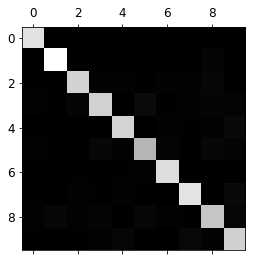

In [64]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

这个混淆矩阵看起来相当不错，因为大多数图像都在主对角线上，这意味着他们被正确分类。5s看起来比其他数字稍暗，这可能意味着数据集中5s的图像较少，或者分类器在5s上的表现不如其他数字。 实际上，您可以验证两者都是如此。

让我们把重点放在错误上：
* 首先，您需要将混淆矩阵中的每个值除以相应类中的图像数量，这样您就可以比较错误率而不是绝对错误数（这会使丰富的类看起来不那么坏）：

In [66]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

现在让我们用 0 来填充对角线。这样子就只保留了被错误分类的数据。让我们画出这个结果。



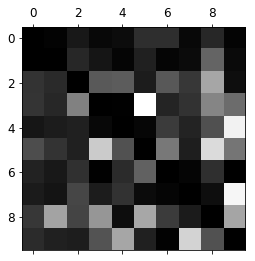

In [67]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

现在我们可以清楚地看到分类器产生的错误类型。需要记住的是，**行表示实际的类**，而**列表示预测的类**：
* 类8和9所在的**列**非常明亮，它告诉您许多图像被错误分类为8或9。
* 类似地，类8和9所在的**行**也非常明亮，告诉你8s和9s经常与其他数字混淆。

相反，有些**行**非常暗：
* 例如第1行：这意味着大多数1都被正确分类（少数与8s混淆，但这就是它）。

请注意，错误并不完全对称：
* 例如，有更多的5被错误分类为8s而不是更多的8 被分类为5。

分析混淆矩阵通常可以为您改进分类方法提供见解。根据这个图，我们的注意力似乎应该花在改进上分类8s和9s上，以及修复特定的3/5混乱的情况：
* 例如，您可以尝试为这些数字收集更多训练数据
* 或者您可以设计有助于分类器的新特征 - 例如，编写算法来计算闭环的数量（例如，8有两个，6有一个，5没有）。
* 或者您可以预处理图像（例如，使用Scikit-Image，Pillow或OpenCV）使某些图案更突出，例如闭环。

**分析个别错误**也可以是一个很好的方式来获得你的分类器正在做什么以及它失败的原因的见解，但它**更困难和耗时**。例如，让我们以绘制3s和5s为例：

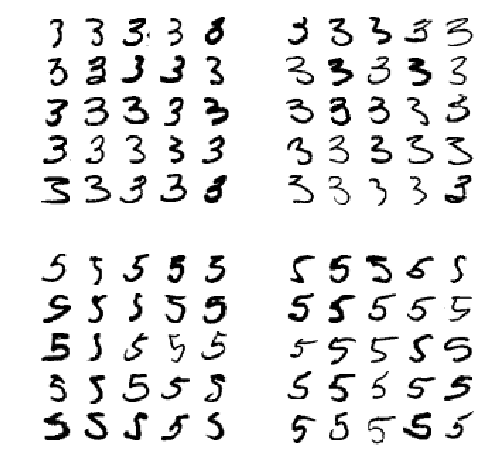

In [69]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

左侧的两个5×5块显示分类为3的数字，右侧两个5×5块显示图像分类为5s。分类器出错的一些数字（即，在左下方和右上方的区域中）写得非常糟糕，甚至是人类将它们分类都有困难（例如，第8行和第1列的5真正看起来像3）。

然而，大多数错误分类的图像对我们来说似乎是明显的错误，并且很难理解分类器为什么会犯错误。**原因**是我们使用了一个简单的SGDClassifier，它是一个线性模型。它所做的只是为每个像素分配每个类别的权重，当它看到一个新图像时，它**只是将加权像素强度相加得到每个类别的分数**。因此，**由于3s和5s仅相差几个像素**，因此该模型很容易混淆它们。

3s和5s之间的主要区别在于连接的小线的位置顶部到底部弧线。如果你绘制一个3，结点稍微偏向左边，分类器可能将其分类为5，反之亦然。换句话说，这个分类器是对图像位移和旋转非常敏感。所以减少3/5混乱的一种方法将是预处理图像，以确保它们很好地居中，而不是旋转。这可能有助于减少其他错误。

### Multilabel classification-多标签分类

到目前为止，所有的样例都总是被分配到仅一个类。有些情况下，你也许想让你的分类器给一个样例输出多个类别。比如说，思考一个人脸识别器。如果对于同一张图片，它识别出几个人，它应该做什么？当然它应该给每一个它识别出的人贴上一个标签。比方说，这个分类器被训练成识别三个人脸，Alice，Bob，Charlie；然后当它被输入一张含有 Alice 和 Bob 的图片，它应该输出[1, 0, 1]（意思是：Alice 是，Bob 不是，Charlie 是）。这种输出多个二值标签的分类系统被叫做多标签分类系统。

目前我们不打算深入脸部识别。我们可以先看一个简单点的例子，仅仅是为了阐明的目的。

In [70]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

此代码创建一个**y_multilabel**数组，这个数组包含每个数字图像的两个目标标签：第一个指示数字是否大（7,8或9），第二个表示它是否是奇数。 下一行创建一个**KNeighborsClassifier**实例（支持多标签分类，但不是所有分类器都支持），我们使用多个目标数组训练它。 现在您可以进行预测，并注意它输出的**两个标签**：

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

它工作正确。数字 5 不是大数（False），同时是一个奇数（True）。

评估多标记分类器的方法有很多种，选择正确的指标实际上取决于您的项目。 例如，一种方法是测量每个单独标签（或前面讨论的任何其他二元分类器度量）的**$F_1$分数**，然后简单地计算平均分数。 此代码计算所有标签的平均$F_1$分数：

这个代码可能会运行很长时间

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9684554018028022

这里假设所有标签有着同等的重要性，但可能不是这样。特别是，如果你的 Alice 的照片比 Bob 或者 Charlie 更多的时候，也许你想让分类器在 Alice 的照片上具有更大的权重。一个简单的选项是：给每一个标签的权重等于它的支持度（比如，那个标签的样例的数目）。为了做到这点，简单地在上面代码中设置average="weighted"。

### Multioutput Classification-多输出分类